In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Train set class distribution: Counter({0: 403, 1: 203})


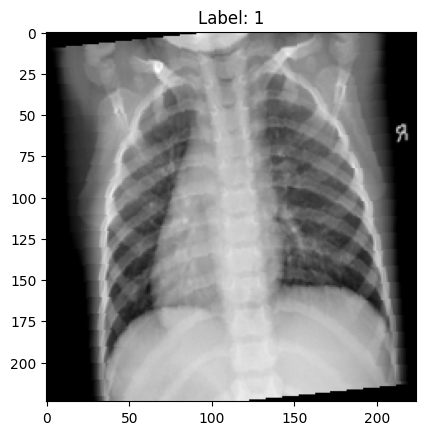

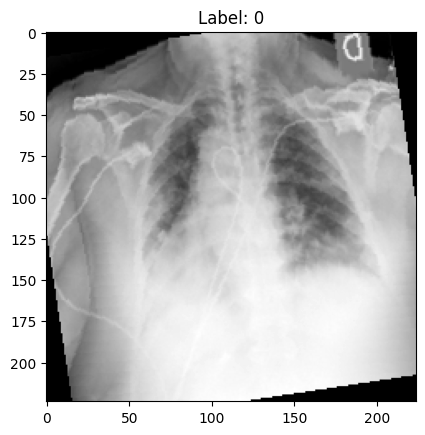

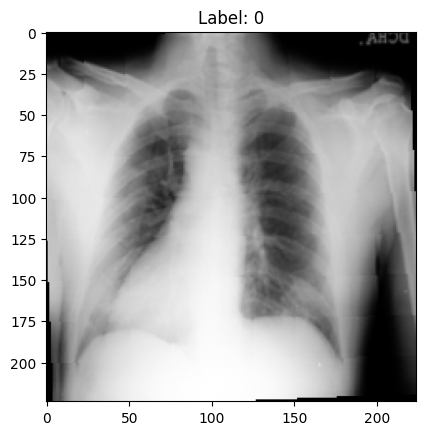

In [9]:
# Define transformations with data augmentation (Highlighted Change 1)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load dataset and automatically split into train, val, and test sets (Highlighted Change 2)
data_path = r"C:\Users\sarva\Desktop\nf\code\covid-dectection-CNN\test"
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Define dataset sizes
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split datasets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify dataset balance
labels = [label for _, label in train_dataset]
print(f"Train set class distribution: {Counter(labels)}")

# Visualize some images and labels
for i in range(3):
    img, label = train_dataset[i]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()



In [16]:

# Define the model
class CovidNet(nn.Module):
    def __init__(self):
        super(CovidNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 26 * 26, 64)
        self.fc2 = nn.Linear(64, 1)  # Raw output for BCEWithLogitsLoss

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No Sigmoid here
        return x

 # Initialize the model, loss function, optimizer, and scheduler (Highlighted Change 3)
model = CovidNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [17]:

# Initialize lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []



In [ ]:
# Start training with validation and model saving (Highlighted Change 4)
print('Starting training...')
num_epochs = 15
best_val_loss = float('inf')  # Track the best validation loss
model_save_path = r"C:\Users\sarva\Desktop\nf\code\edochetta\model4.pth"  # Path to save the model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()  # Ensure labels are in the correct shape

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Apply Sigmoid here for prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    train_accuracy = 100 * correct / total
    train_precision = precision_score(all_labels, all_predictions)
    train_recall = recall_score(all_labels, all_predictions)
    train_f1 = f1_score(all_labels, all_predictions)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)
    print(f'Epoch {epoch + 1} Training Loss: {train_losses[-1]:.4f} Accuracy: {train_accuracy:.2f}% Precision: {train_precision:.2f} Recall: {train_recall:.2f} F1: {train_f1:.2f}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_predictions = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.view(-1, 1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_val_labels.extend(labels.cpu().numpy())
            all_val_predictions.extend(predicted.cpu().numpy())

    val_accuracy = 100 * correct_val / total_val
    val_precision = precision_score(all_val_labels, all_val_predictions)
    val_recall = recall_score(all_val_labels, all_val_predictions)
    val_f1 = f1_score(all_val_labels, all_val_predictions)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    print(f'Epoch {epoch + 1} Validation Loss: {val_losses[-1]:.4f} Accuracy: {val_accuracy:.2f}% Precision: {val_precision:.2f} Recall: {val_recall:.2f} F1: {val_f1:.2f}')

    # Step the scheduler
    scheduler.step()

    # Save the model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved at epoch {epoch + 1}")

print('Finished Training')


Starting training...
Epoch 1 Training Loss: 0.7029 Accuracy: 60.89% Precision: 0.36 Recall: 0.21 F1: 0.26
Epoch 1 Validation Loss: 0.6172 Accuracy: 71.32% Precision: 0.59 Recall: 0.44 F1: 0.51
Model saved at epoch 1
Epoch 2 Training Loss: 0.5454 Accuracy: 75.41% Precision: 0.72 Recall: 0.43 F1: 0.54
Epoch 2 Validation Loss: 0.4619 Accuracy: 79.84% Precision: 0.90 Recall: 0.44 F1: 0.59
Model saved at epoch 2
Epoch 3 Training Loss: 0.4949 Accuracy: 79.21% Precision: 0.75 Recall: 0.57 F1: 0.65
Epoch 3 Validation Loss: 0.4424 Accuracy: 76.74% Precision: 0.62 Recall: 0.77 F1: 0.69
Model saved at epoch 3
Epoch 4 Training Loss: 0.4428 Accuracy: 82.51% Precision: 0.82 Recall: 0.62 F1: 0.70
Epoch 4 Validation Loss: 0.4719 Accuracy: 73.64% Precision: 0.59 Recall: 0.67 F1: 0.63
Epoch 5 Training Loss: 0.4222 Accuracy: 82.34% Precision: 0.83 Recall: 0.60 F1: 0.69
Epoch 5 Validation Loss: 0.4112 Accuracy: 78.29% Precision: 0.94 Recall: 0.37 F1: 0.53
Model saved at epoch 5
Epoch 6 Training Loss: 0.40

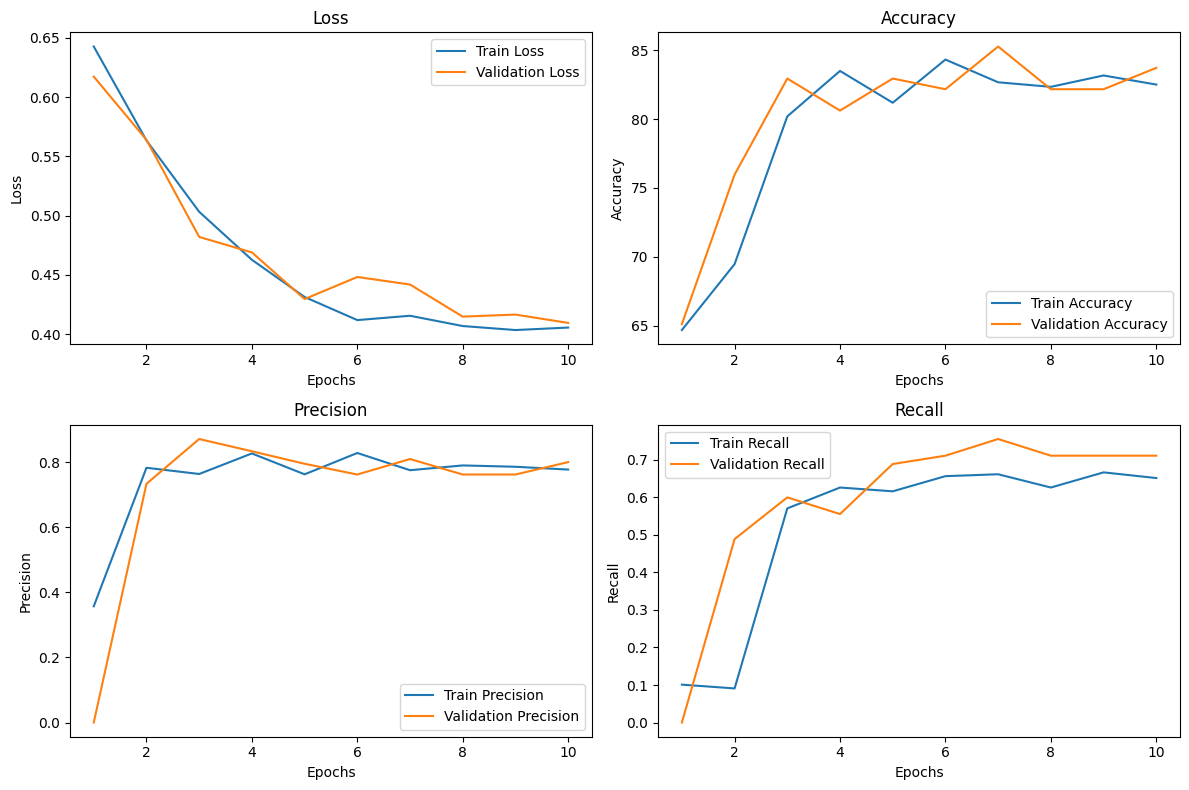

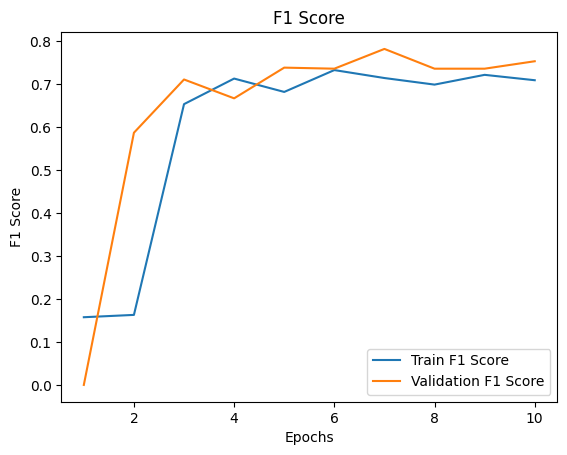

In [6]:

# Plotting the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs, train_f1s, label='Train F1 Score')
plt.plot(epochs, val_f1s, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score')
plt.show()


In [7]:

# Test the model (Highlighted Change 5)
print('Testing the model...')
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f} Accuracy: {test_accuracy:.2f}%")


Testing the model...
Test Loss: 0.5256 Accuracy: 81.68%
